In [5]:
from PIL import Image, ImageStat
from PIL.ImageDraw import ImageDraw

import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

from random import randint
from math import pi

import os
from os import path

from fastai import vision
from fastai.vision import ImageList, FloatList, cnn_learner, pil2tensor, open_image
from fastai.callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, CSVLogger
from fastai.train import ShowGraph, Learner
from fastai.metrics import mean_absolute_error, mean_squared_error
from torchvision import models
from torch import nn
import numpy as np

from functools import partial

## Local Imports ##
from models import helpers as model_helpers, models as custom_models
from datasets import helpers as dataset_helpers

## Dataset

In [6]:
DT_LEN = 25000
COUNT = True
ROOT_DIR = 'data'
DT_ROOT_DIR = 'polygon_data_counts' if COUNT else 'polygon_data'
DT_ROOT_DIR = path.join(ROOT_DIR, DT_ROOT_DIR)
DT_ROOT_DIR = path.abspath(DT_ROOT_DIR)
MODEL_ROOT_DIR = path.join(DT_ROOT_DIR, 'results')
W, H = 512, 512
BATCH_SIZE = 64

DATASETS = [
        {"root_dir": path.join(ROOT_DIR, "polygon_data_counts"), "count": True},
        {"root_dir": path.join(ROOT_DIR, "polygon_data_percentage"), "count": False}
    ]

for dataset in DATASETS:
    df_train = dataset_helpers.gen_df(dataset["root_dir"], DT_LEN, skip=True, test=False, count=dataset["count"])
    df_test  = dataset_helpers.gen_df(dataset["root_dir"], DT_LEN, skip=True, test=True, count=dataset["count"])

Found existing dataset, skipping...
Found existing dataset, skipping...
Found existing dataset, skipping...
Found existing dataset, skipping...


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

def get_dataset(train_dir, test_dir, df_train, df_test, bs, transform_args):
    test_item_list = (ImageList
        .from_df(path=path.join(DT_ROOT_DIR, 'test', 'images'), df=df_test, convert_mode='1')
    )
    return (ImageList
            .from_df(path=path.join(DT_ROOT_DIR, 'train', 'images'), df=df_train, convert_mode='1')
            .split_by_rand_pct()
            .label_from_df(cols=1, label_cls=FloatList)
            .transform(**transform_args)
            .add_test(test_item_list)
            .databunch(bs=bs, device=device)  
        )

DT_ROOT_DIR = 'data/polygon_data_percentage'
df_train = pd.read_csv(f"{DT_ROOT_DIR}/train/data.csv", index_col=0)
df_test = pd.read_csv(f"{DT_ROOT_DIR}/test/data.csv", index_col=0)


get_dataset(
    path.join(DT_ROOT_DIR, 'train', 'images'),
    path.join(DT_ROOT_DIR, 'test', 'images'),
    df_train,
    df_test,
    64,
    {"size": (512, 512)}
)

Device: cuda


ImageDataBunch;

Train: LabelList (20000 items)
x: ImageList
Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512)
y: FloatList
0.059143066,0.0031585693,0.04852295,0.05199051,0.007537842
Path: data/polygon_data_percentage/train/images;

Valid: LabelList (5000 items)
x: ImageList
Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512)
y: FloatList
0.013114929,0.20076752,0.04044342,0.050930023,0.0018310547
Path: data/polygon_data_percentage/train/images;

Test: LabelList (25000 items)
x: ImageList
Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512)
y: EmptyLabelList
,,,,
Path: data/polygon_data_percentage/train/images

## Model Training

In [8]:
MAX_EPOCHS = 10
EARLY_STOP_PATIENCE = 5
REDUCE_ON_PLATEAU_PATIENCE = 2

l1 = nn.L1Loss()
loss_func = lambda i,t: l1(i.squeeze(), t)



### Baseline Model (MLP)

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

metrics = [
    mean_squared_error,
    mean_absolute_error
]

learn = Learner(
    model=nn.Sequential(Flatten(), nn.Linear(W * H, 1)),
    data=bunch,
    path=f"{MODEL_ROOT_DIR}/mlp",
    callback_fns=[
        partial(EarlyStoppingCallback, patience=EARLY_STOP_PATIENCE), 
        partial(ReduceLROnPlateauCallback, patience=REDUCE_ON_PLATEAU_PATIENCE),
        partial(CSVLogger, filename=f"history_mlp")
    ],
    metrics=metrics,
    silent=False
)
learn.fit(MAX_EPOCHS)
save_stats(learn, 'mlp')
learn.save("mlp")

NameError: name 'bunch' is not defined

Epoch 9: reducing lr to 0.0006000000000000001


Epoch 3: reducing lr to 0.0006000000000000001


Epoch 7: reducing lr to 0.0006000000000000001


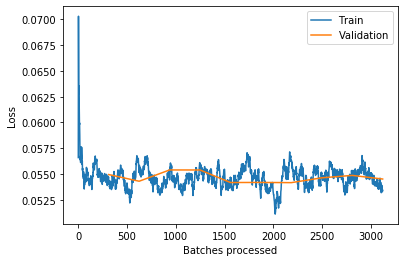

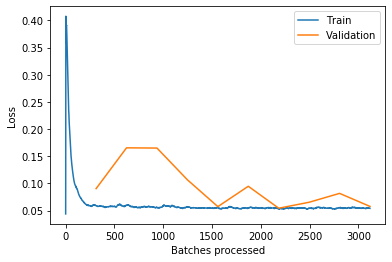

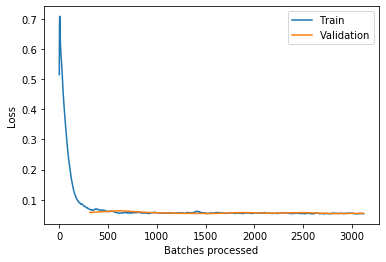

In [7]:
for model in custom_models.get_models():
    learn = cnn_learner(
        data=bunch,
        path=path.join(MODEL_ROOT_DIR, model["name"]),
        base_arch=lambda t: model["model"],
        cut=lambda x: x,
        loss_func=loss_func,
        callback_fns=[
            partial(EarlyStoppingCallback, patience=EARLY_STOP_PATIENCE), 
            partial(ReduceLROnPlateauCallback, patience=REDUCE_ON_PLATEAU_PATIENCE),
            partial(CSVLogger, filename=f"history_{model['name']}")
        ],
        metrics=metrics,
        silent=True
    )
    learn.fit(MAX_EPOCHS)
    save_stats(learn, model["name"])
    learn.save(model["name"])

In [9]:
summarize_results([*models, {"name":"mlp"}], MODEL_ROOT_DIR)

TypeError: 'module' object is not iterable